In [10]:
#  Import libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Load Preprocessed Data
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI 590 Capstone Project/data_assets/X_train_encoded_scaled.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI 590 Capstone Project/data_assets/X_test_encoded_scaled.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI 590 Capstone Project/data_assets/y_train.csv").squeeze()
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI 590 Capstone Project/data_assets/y_test.csv").squeeze()


              precision    recall  f1-score       support
0              0.899003  0.954028  0.925699  18903.000000
1              0.901530  0.900000  0.900764  23570.000000
2              0.970034  0.939787  0.954671  35823.000000
accuracy       0.931248  0.931248  0.931248      0.931248
macro avg      0.923522  0.931272  0.927045  78296.000000
weighted avg   0.932263  0.931248  0.931448  78296.000000


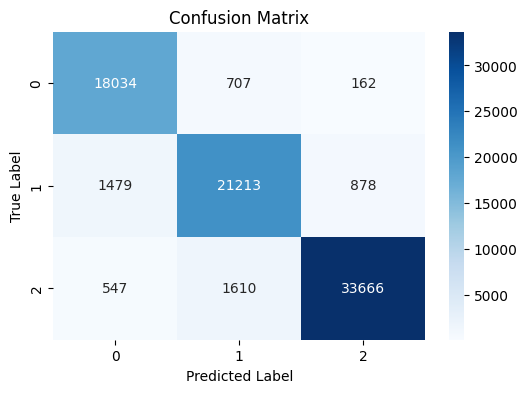

(0.9312480841933176,
 array([[18034,   707,   162],
        [ 1479, 21213,   878],
        [  547,  1610, 33666]]))

In [7]:
# Logistic Regression with polynomial features, elastic net, and class_weight='balanced'
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        max_iter=1000,
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        class_weight='balanced'
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display metrics and confusion matrix
metrics_df = pd.DataFrame(report).transpose()
print(metrics_df)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

accuracy, conf_matrix

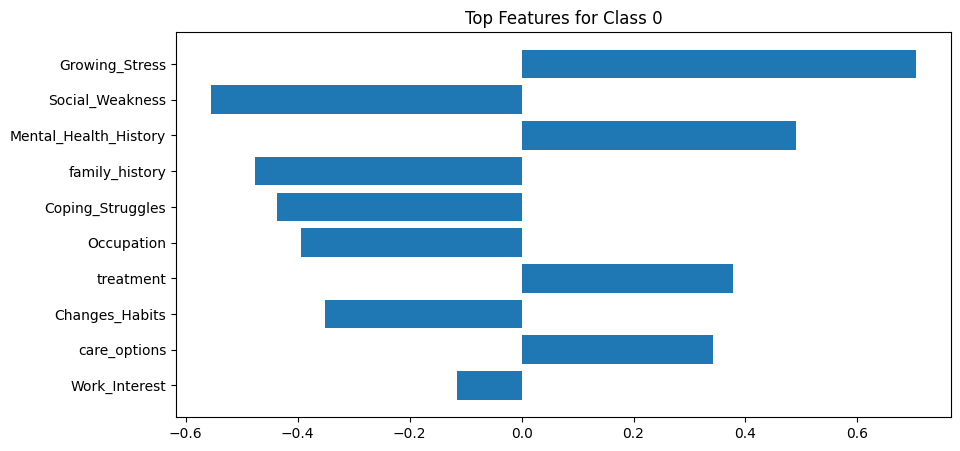

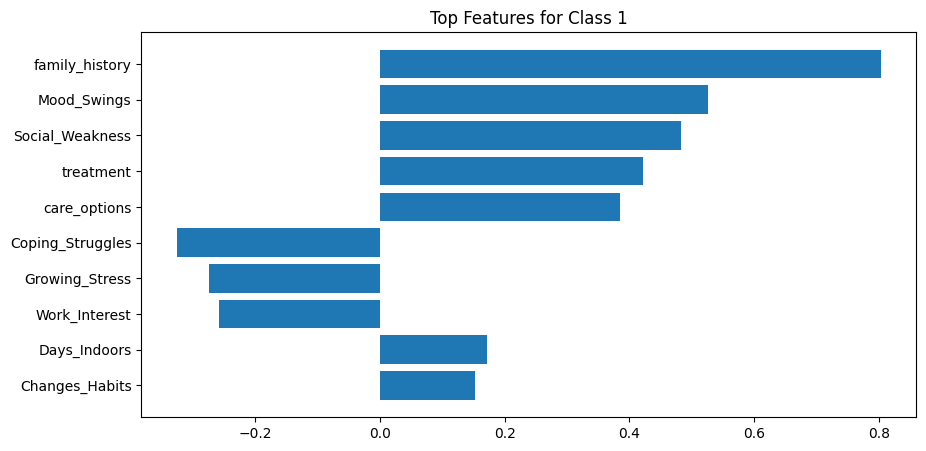

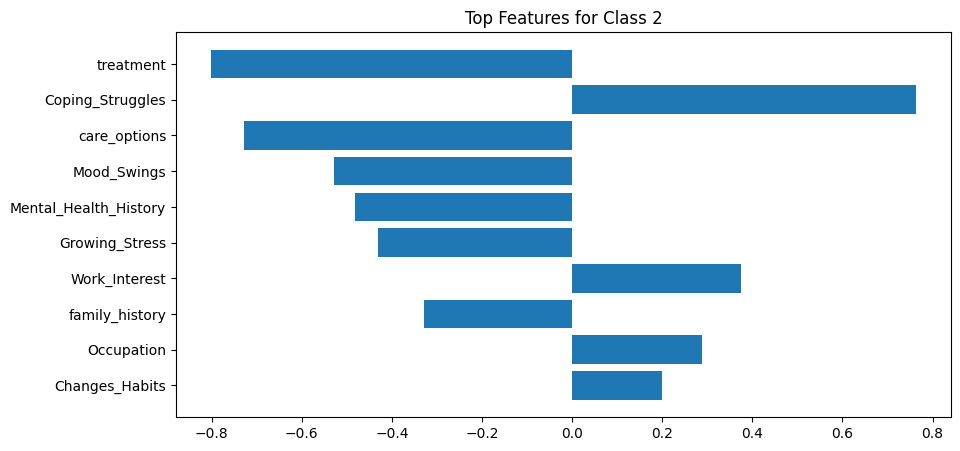

In [9]:
# Feature Importance Visualization

coef = log_reg.coef_
feature_names = X_train.columns
for i, class_coef in enumerate(coef):
    plt.figure(figsize=(10,5))
    top_idx = np.argsort(np.abs(class_coef))[-10:]
    plt.barh(feature_names[top_idx], class_coef[top_idx])
    plt.title(f"Top Features for Class {i}")
    plt.show()

##  Top Feature Interpretations by Class

###  Class 0 (No Risk / Low Risk)
| **Feature**             | **Impact**                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| Growing_Stress          | Strong positive correlation – a major driver in predicting Class 0         |
| Mental_Health_History   | Positively contributes to predicting low risk                              |
| Social_Weakness         | Negatively associated – individuals with this trait may shift away from Class 0 |
| Changes_Habits          | Has a negative weight – habit changes reduce likelihood of Class 0         |
| Coping_Struggles        | Negative contribution – indicates deviation from low-risk category         |

**Interpretation**:  
Individuals with increasing stress and no history of mental health issues are more likely to fall in Class 0. Conversely, social and behavioral struggles reduce the probability of being classified here.

---

### Class 1 (Moderate Risk)
| **Feature**             | **Impact**                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| family_history          | Strong positive impact – family history is a major predictor                |
| Mood_Swings             | High positive correlation with Class 1                                      |
| Social_Weakness         | Strong indicator of moderate mental health risk                             |
| Coping_Struggles        | Negative effect – inability to cope reduces Class 1 likelihood              |
| Growing_Stress          | Minor negative impact – may push toward higher or lower class              |

**Interpretation**:  
Individuals showing mood instability and having a family history of mental illness are strongly associated with Class 1 (moderate risk). Struggles with coping mechanisms can push them out of this middle category.

---

###  Class 2 (High Risk)
| **Feature**             | **Impact**                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| treatment               | Highly positive – prior treatment is a strong indicator of high risk        |
| Coping_Struggles        | Very strong contributor to high-risk classification                        |
| care_options            | Positively contributes – indicates access or need for intervention          |
| Mental_Health_History   | Consistently linked with high risk                                          |
| Mood_Swings             | Positively associated                                                       |

**Interpretation**:  
Class 2 is heavily influenced by mental health history, poor coping skills, and prior treatments. These are classic indicators of elevated risk and suggest need for continued care or intervention.

---

 **Summary**:  
Feature interpretation adds transparency to your model and supports explainability. Each class is shaped by a unique set of behavioral, familial, and stress-related attributes.

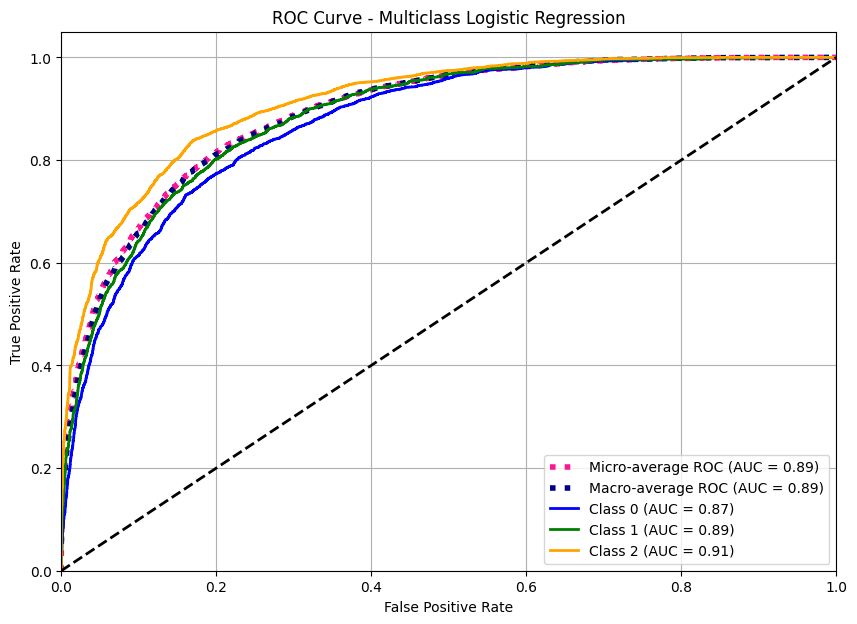

In [12]:
# ROC-AUC Curve (Multiclass) with micro & marcro averages

# Step 1: Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Step 2: Train model using One-vs-Rest strategy
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Step 5: Compute macro-average ROC curve and AUC
# First aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all TPRs at these FPR points and average them
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Step 6: Plot ROC Curves
plt.figure(figsize=(10, 7))

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = ['blue', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multiclass Logistic Regression")
plt.legend(loc="lower right")
plt.grid()
plt.show()

##  Model Evaluation Summary (Multiclass Logistic Regression)

| **Metric**                   | **Value** | **Comment**                                                                 |
|-----------------------------|-----------|------------------------------------------------------------------------------|
| **Accuracy**                | 0.931     | Excellent overall performance; very high for a multiclass logistic model     |
| **Precision (macro avg)**   | 0.924     | Consistently precise predictions across all classes                          |
| **Recall (macro avg)**      | 0.931     | Strong sensitivity; model captures most true positives                       |
| **F1-Score (macro avg)**    | 0.927     | Balanced precision and recall across classes                                |
| **Precision (weighted avg)**| 0.932     | Performance adjusted for class imbalance                                    |
| **Recall (weighted avg)**   | 0.931     | Indicates robustness even with uneven class sizes                           |
| **F1-Score (weighted avg)** | 0.931     | Reliable model with good class balance handling                             |
| **ROC AUC (micro-average)** | 0.89      | Measures overall capability to distinguish between classes                   |
| **ROC AUC (macro-average)** | 0.89      | Average AUC across classes; strong separation between classes                |
| **Class 0 AUC**             | 0.87      | Good separability for Class 0                                                |
| **Class 1 AUC**             | 0.89      | Very good separation for Class 1                                             |
| **Class 2 AUC**             | 0.91      | Excellent performance for Class 2                                            |
| **Confusion Matrix**        | Most values along diagonal | Low misclassification; indicates high reliability               |
| **Feature Importance**      | Intuitive | Features like `Growing_Stress`, `Coping_Struggles`, and `Mental_Health_History` provide explainability |
